# DeepONet

In [1]:
import os
# os.environ['JAX_PLATFORMS'] = 'cpu'

import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import itertools
from functools import partial
from tqdm import trange

from pidon.mlp import MLP
from pidon.dataset import DataGenerator
from pidon.data.antiderivative import generate_training_data, generate_test_data

In [2]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=jnp.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=jnp.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()
        # Logger
        self.loss_log = []

    # Define opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = jnp.sum(B * T)
        return outputs
      
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y

    # Define loss
    def loss(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N, 1)
        # outputs: s, shape = (N, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)

                # Print loss during training
                pbar.set_postfix({'Loss': loss_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

In [3]:
m = 100     # Number of locations for evaluating the input functions u

In [4]:
# Initialize model

branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]

model = DeepONet(branch_layers, trunk_layers)

# Before training

In [5]:
key_test = random.PRNGKey(0)
l_test = 0.2
N_test = 2
m_test = m    
P_test = 100

u_test, y_test, s_test = \
    generate_test_data(key_test, l_test, N_test, m_test, P_test)

In [6]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:, None]
u_pred = model.predict_s_y(params, u_test, y_test)

In [7]:
print(u_test.shape)
print(y_test.shape)

print(s_pred.shape)
print(u_pred.shape)

(200, 100)
(200, 1)
(200, 1)
(200, 1)


In [8]:
idx=0
index = jnp.arange(idx * P_test, (idx + 1) * P_test)
index

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],      dtype=int32)

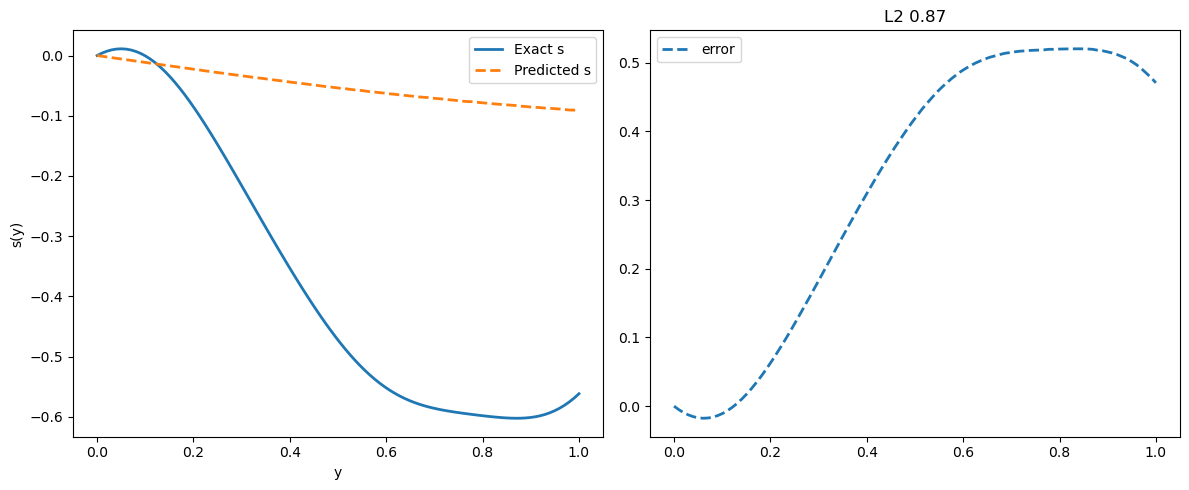

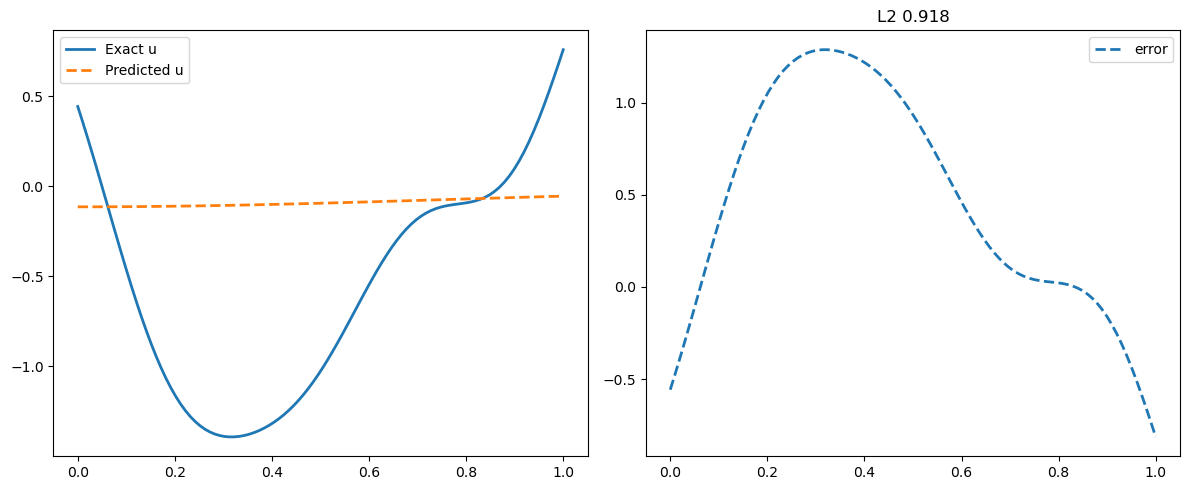

In [9]:
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
l2_error = jnp.linalg.norm(s_test[index, :] - s_pred[index, :]) / jnp.linalg.norm(s_test[index, :])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], u_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], u_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
l2_error = jnp.linalg.norm(u_test[::P_test][idx] - u_pred[index,:].flatten()) / jnp.linalg.norm(u_test[::P_test][idx])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [10]:
key_train = random.PRNGKey(0)
l_train = 0.2  
N_train = 10000
m_train = m
P_train = 1
Q_train = 1

u_train, y_train, s_train, _, _, _ = \
    generate_training_data(key_train, l_train, N_train, m_train, P_train, Q_train)

In [11]:
y_train, s_train

(Array([[0.7425288 ],
        [0.23492004],
        [0.19262293],
        ...,
        [0.2387453 ],
        [0.39193752],
        [0.70940167]], dtype=float32),
 Array([[ 0.49643666],
        [ 0.08384103],
        [-0.10456819],
        ...,
        [ 0.08367722],
        [-0.59472394],
        [ 0.07205312]], dtype=float32))

In [12]:
# Create data set
batch_size = 10000

dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [13]:
# Train

model.train(dataset, nIter=40000)

100%|██████████| 40000/40000 [00:35<00:00, 1122.15it/s, Loss=9.707787e-06]  


In [14]:
path = os.path.abspath('./TrainedModel/deeponet')
os.makedirs(path, exist_ok=True)

params_path = os.path.join(path, 'params.npy')
loss_path = os.path.join(path, 'loss.npy')

# Save the trained model
params = model.get_params(model.opt_state)
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
jnp.save(params_path, flat_params)
jnp.save(loss_path, model.loss_log)

# Restore the trained model
flat_params = jnp.load(params_path)
params = model.unravel_params(flat_params)

# Restore loss
loss = jnp.load(loss_path)

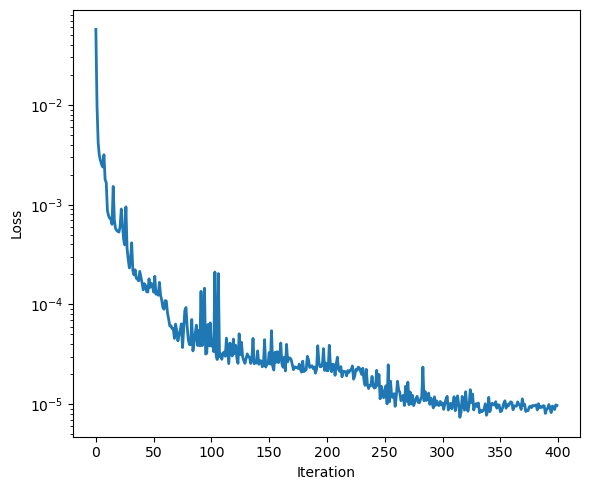

In [15]:
plt.figure(figsize = (6,5))
plt.plot(loss, lw=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

# After training

In [16]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:, None]
u_pred = model.predict_s_y(params, u_test, y_test)

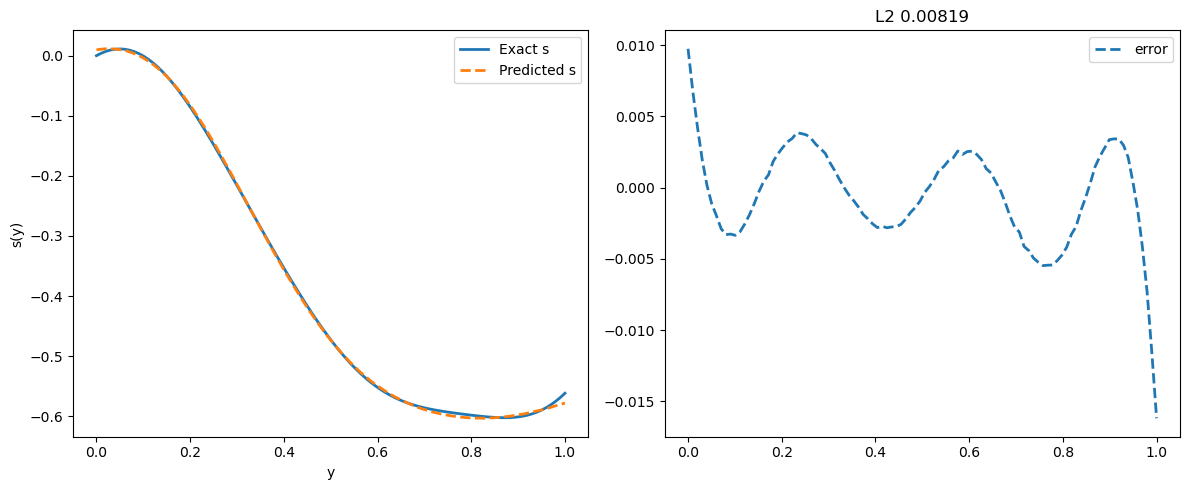

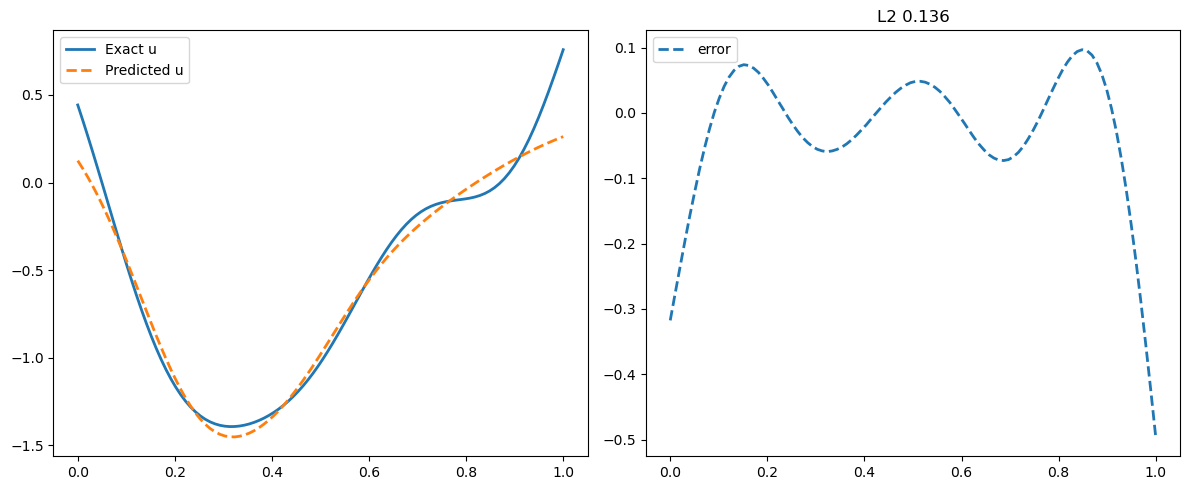

In [17]:
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
l2_error = jnp.linalg.norm(s_test[index, :] - s_pred[index, :]) / jnp.linalg.norm(s_test[index, :])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], u_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], u_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
l2_error = jnp.linalg.norm(u_test[::P_test][idx] - u_pred[index,:].flatten()) / jnp.linalg.norm(u_test[::P_test][idx])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()